In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib.pyplot as plt
from matplotlib import gridspec


# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# 1d example

In [2]:
def logistic(X):
    return 1. / (1. + np.exp(-X))

def ex_mean_fun(X):
    return np.squeeze(np.sin(X))
def ex_cov_fun(X):
    N = X.shape[0]
    return np.zeros((N, N))

def sin_rate_fun(X, upper_bound):
    mean_vals = ex_mean_fun(X)
    cov_vals  = ex_cov_fun(X)
    return logistic(np.random.multivariate_normal(mean_vals, cov_vals)) * upper_bound 

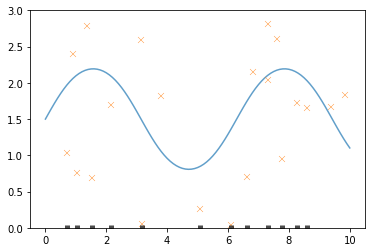

In [3]:
Tmin = 0
Tmax = 10
upper_bound = 3

samples, _, all_samples, R = get_scp_samples(lambda x: sin_rate_fun(x, upper_bound=upper_bound), np.array([[Tmin,Tmax]]), upper_bound = upper_bound)
X = np.linspace(Tmin,Tmax, 101)
y = sin_rate_fun(X, upper_bound)

plt.plot(X, y, alpha=.7)
plt.plot(all_samples, R , 'x', mew=.4)
plt.plot(samples, np.zeros(samples.shape[0]), 'k|', mew=5, alpha=.7)
plt.ylim(0, upper_bound)
plt.show()

# Variational Approximation

### 1D Parameter Learning

In [13]:
def learn_parameters(ind_point_res) :  
    ## ######## ##
    # PARAMETERS #
    ## ######## ##
    log_dir = 'logs'
    max_iterations = 100

    # inducing point location
    Z = np.expand_dims(np.linspace(Tmin, Tmax, ind_point_res),axis=1)

    ## ######### ##
    # BUILD GRAPH #
    ## ######### ##
    tf.reset_default_graph()
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S, interesting_gradient, K_zz_inv = build_graph(Z.shape[0])

    with tf.name_scope('optimization'):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(-lower_bound)

    ## ########## ##
    # OPTIMIZATION #
    ## ########## ##
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter(log_dir, sess.graph)

        S_init_val = sess.run([S])

        for i in range(max_iterations):
            bound,_, m_val, S_val, grad_val, summary,Kzz_inv = sess.run([lower_bound,train_step, m, S, interesting_gradient, merged,K_zz_inv], feed_dict={Z_ph:Z, u_ph:0.,X_ph:samples})
            writer.add_summary(summary, i)
    return m_val,S_val,Kzz_inv,Z

#### 1D Evaluation

In [16]:

def evaluate(eval_points, m_val, S_val, Kzz_inv,Z):
    #build graph
    lam,lam_var, Z_ph,X_eval_ph,K_zz_inv_ph, S_ph, m_ph  = build_eval_graph(Z.shape[0])

    #run session
    with tf.Session() as sess:
        lam_vals,lam_var_vals, = sess.run([lam,lam_var], feed_dict={Z_ph:Z, X_eval_ph:eval_points,K_zz_inv_ph: Kzz_inv,S_ph:S_val,m_ph:m_val})

    var1 = lam_vals[0,:]+lam_var_vals[0,:]
    var2 = lam_vals[0,:]-lam_var_vals[0,:]

    return lam_vals, var1,var2

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Number inducing points:  5.0


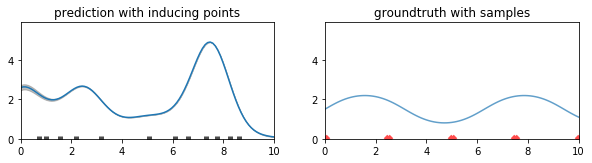

Number inducing points:  6.0


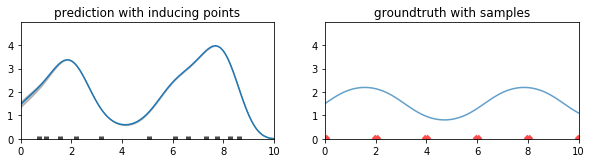

Number inducing points:  7.0


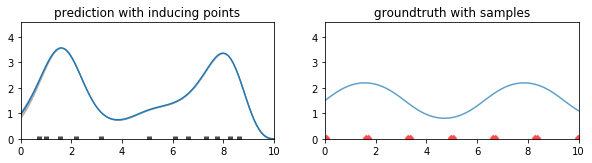

Number inducing points:  8.0


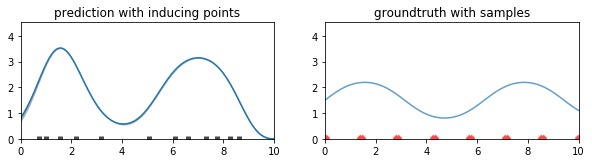

Number inducing points:  9.0


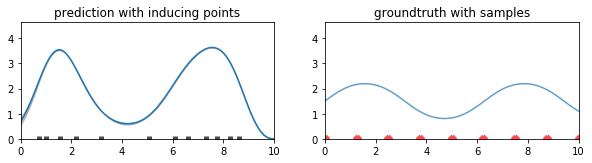

Number inducing points:  10.0


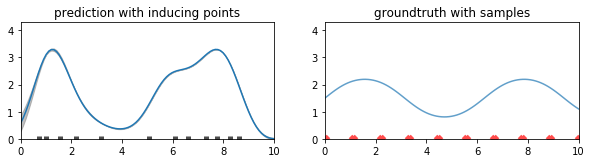

In [19]:
num_iterations = 6
eval_res = 100
eval_points = np.expand_dims(np.linspace(Tmin, Tmax, eval_res),axis=1)
counter = 1

for i in np.linspace(5,10,num_iterations):

    m,S,Kzz_inv,Z = learn_parameters(i)
    lam_vals, var1, var2 = evaluate(eval_points,m,S,Kzz_inv,Z)

    #plots
    cmap = plt.get_cmap('plasma')
    fig = plt.figure(figsize=(10,15))

    print('Number inducing points: ',i)

    ax0 = plt.subplot(num_iterations,2,counter)
    ax0.plot(eval_points[:,0],lam_vals[0,:])
    ax0.set_title('prediction with inducing points')
    ax0.plot(samples, np.zeros(samples.shape[0]), 'k|', mew=5, alpha=.7)
    ax0.fill_between(eval_points[:,0], var1, var2, color='grey', alpha='0.5')
    plt.ylim(0, np.max(lam_vals)+1)
    plt.xlim(Tmin, Tmax )

    ax1 = plt.subplot(num_iterations,2,counter+1)
    ax1.plot(X, y, alpha=.7)    
    ax1.plot(Z[:, 0], np.zeros(Z.shape[0]),'rx', mew=5, alpha=.7)
    ax1.set_title('groundtruth with samples')
    plt.ylim(0, np.max(lam_vals)+1)
    plt.xlim(Tmin, Tmax )
    plt.show()
    counter += 2